In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string

In [2]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [5]:
# from scipy.linalg import svd

# from sklearn.decomposition import PCA

from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

In [6]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

In [7]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [8]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [9]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### Let's continue to brush aside the Named Entity issue in 'overview'

#### Start by removing digits, capital letters and punctuation

In [10]:
alpha = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_and_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

movies['plot_tokens'] = movies['overview'].map(alpha).map(punc_and_lower)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


In [11]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


#### Tokenize plot summaries - start with simple NLTK word_tokenize:

In [12]:
movies['plot_tokens'] = movies['plot_tokens'].map(word_tokenize)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


In [13]:
movies['director'] = movies['director'].map(lambda x: [x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


#### Combine all tokens into one 'corpus' column

In [14]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [15]:
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,...",adventure animation children comedy fantasy jo...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a...",adventure children fantasy joe_johnston robin_...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ...",comedy romance howard_deutch walter_matthau ja...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th...",comedy drama romance forest_whitaker whitney_h...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr...",comedy charles_shyer steve_martin diane_keaton...


In [16]:
movies['corpus'][0]

'adventure animation children comedy fantasy john_lasseter tom_hanks tim_allen don_rickles jim_varney led by woody andy s toys live happily in his room until andy s birthday brings buzz lightyear onto the scene afraid of losing his place in andy s heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences '

#### Initially, let's skip stemming and just go straight to vectorizing

#### Will try n-grams from 1, 2 and 3 this time

In [17]:
cv1 = CountVectorizer(stop_words='english', ngram_range=(1, 3))

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())

In [18]:
doc_term.shape

(47723, 2864786)

#### The above looks like way too many columns - let's adjust max_df & min_df

In [21]:
cv1 = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.03, ngram_range=(1, 3))

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())

In [22]:
doc_term.shape

(47723, 92)

In [23]:
doc_term.head()

,action,action adventure,adventure,american,animation,begins,best,boy,brother,children,city,comedy,comedy drama,comedy romance,comes,crime,crime drama,daughter,day,death,decides,discovers,documentary,drama,drama romance,drama thriller,falls,family,fantasy,father,fi,film,finds,friend,friends,gets,girl,goes,group,help,high,home,horror,house,husband,job,just,life,lives,living,local,long,love,make,man,meets,men,mother,murder,mysterious,mystery,new,night,old,people,police,romance,school,sci,sci fi,secret,set,small,son,soon,story,takes,thriller,time,town,tries,war,way,western,wife,woman,work,world,year,year old,years,young
0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### Now apply dimensionality reduction to the dataset

In [24]:
svd = TruncatedSVD(n_components=40, n_iter=20, random_state=42)
svd.fit(X_cv1.T)

TruncatedSVD(n_components=40, n_iter=20, random_state=42)

In [25]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.07016261 0.04946086 0.03947124 0.03048168 0.02980708 0.02805426
 0.0256762  0.02423964 0.02284922 0.02221774 0.02100243 0.02011641
 0.01966191 0.0189003  0.01768929 0.01711055 0.01509651 0.01556075
 0.01485594 0.0142813  0.01386693 0.01360838 0.01288901 0.01288656
 0.01221855 0.01196183 0.01164261 0.01055148 0.01049243 0.01035987
 0.00985509 0.00973977 0.00966522 0.00919351 0.00900242 0.00878546
 0.00859933 0.00845885 0.0084157  0.00824163]
0.7271305634866494


In [26]:
svd.components_.T.shape

(47723, 40)

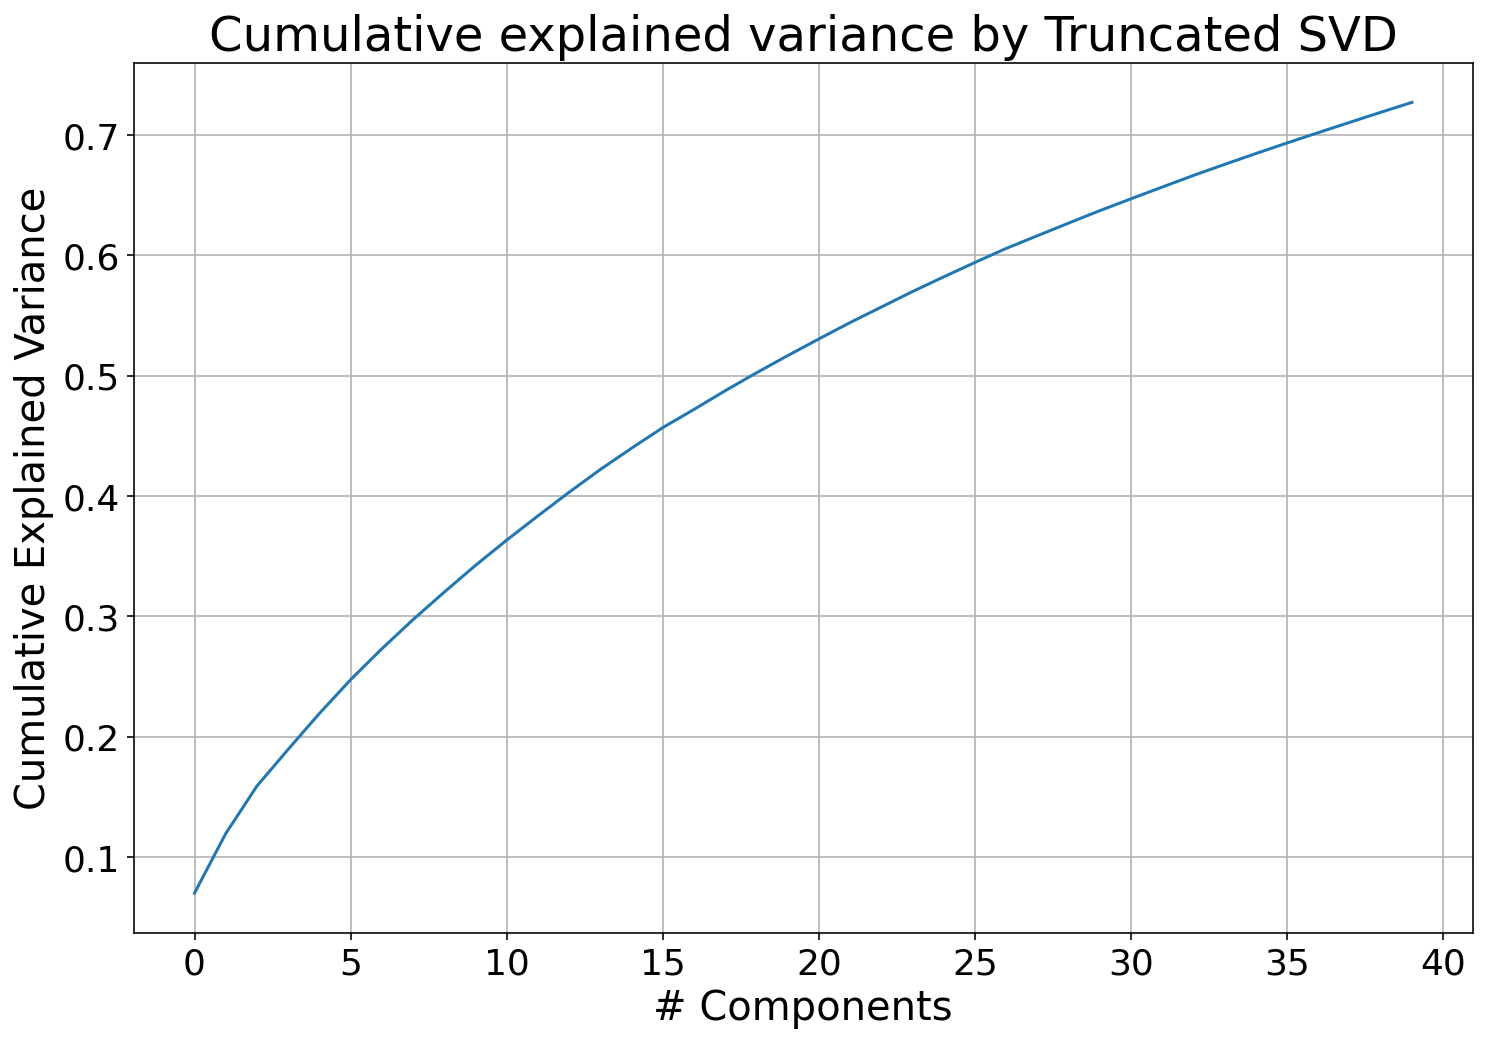

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid();

In [28]:
mat = pd.DataFrame(data=svd.components_.T, index=movies.index)
mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.002388,0.007128,0.003282,-0.000763,0.000784,-0.004026,-0.002249,0.001209,0.003024,-0.004262,-0.002015,0.004864,0.001838,-0.004293,-0.003841,0.001306,0.005151,-0.013726,-0.000534,-0.009989,-0.005005,-0.000163,-0.002283,-0.001397,-0.002458,-0.004911,-0.003002,-0.001829,-0.000343,-0.000583,0.003360,-0.001202,0.001715,-0.001700,0.001380,0.001496,-0.001025,-0.001552,-0.000044,-0.001030
1,0.001808,0.000797,0.003587,0.004310,0.002360,-0.003932,-0.001924,0.003328,0.004616,-0.002112,-0.000726,0.002995,0.001886,-0.002652,-0.001424,0.000846,0.008044,-0.016920,-0.005987,-0.003419,0.001400,0.002477,0.000610,-0.005222,0.000535,-0.001974,0.001786,-0.003810,0.002671,0.013445,0.005922,-0.003840,0.002371,-0.004096,0.000967,-0.000891,-0.000905,-0.001049,-0.000664,-0.000108
2,0.003621,0.008451,-0.000775,-0.001561,0.000893,0.002350,-0.000467,-0.000940,0.003687,0.002344,0.004643,0.005289,-0.006727,0.000780,0.003687,-0.008158,-0.000606,-0.001151,0.000929,0.002655,-0.001086,-0.004395,0.005717,0.003666,-0.002050,0.010386,-0.004809,-0.001317,0.001623,-0.002671,0.002540,-0.002226,0.000871,-0.000474,0.000442,0.000380,-0.000945,-0.001743,-0.000481,0.001171
3,0.007338,0.005544,-0.005752,-0.005507,0.005229,0.002279,0.000068,-0.001833,-0.003057,-0.000591,-0.002211,-0.002975,-0.004218,0.007733,-0.006299,-0.006061,0.000886,-0.004382,-0.000474,0.003371,-0.001192,0.002526,-0.002215,-0.000268,-0.003839,0.000596,-0.003042,-0.001996,-0.003571,0.001286,-0.007539,0.001653,-0.006542,0.000819,-0.007829,0.002787,-0.000726,0.008602,0.004209,-0.000628
4,0.002527,0.006228,0.000878,-0.002140,-0.002703,-0.001160,-0.001704,-0.000252,-0.000758,-0.000810,0.002142,0.000191,-0.001758,0.001135,0.000051,0.000808,0.002561,0.002577,-0.001158,-0.003783,-0.000217,-0.001170,0.006446,-0.001610,-0.000839,-0.001706,0.014311,0.000541,0.001639,-0.006497,0.001969,0.003413,-0.003451,-0.004181,-0.001843,-0.011224,-0.003380,0.004299,0.012606,0.002887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,0.007117,-0.002406,-0.002224,0.008159,-0.006394,-0.003896,-0.012420,-0.005132,0.006878,0.003200,-0.006549,-0.005156,-0.001373,-0.003752,-0.000342,0.000825,0.015645,0.014222,-0.013866,0.000129,-0.001678,-0.000630,0.016014,0.006331,-0.008686,0.022584,-0.007889,0.007008,-0.006866,0.011865,0.028984,0.035045,-0.003810,0.003206,0.002791,-0.003079,0.000455,-0.000595,-0.015217,-0.022818
47719,0.003665,0.012302,0.001098,-0.005958,-0.003233,-0.003043,-0.000768,-0.000268,-0.003335,-0.002070,0.001767,-0.001098,-0.001603,0.000178,0.000241,0.001280,0.000649,0.001921,-0.001470,-0.002951,-0.000382,-0.001277,0.005714,-0.000842,-0.000288,-0.001132,0.011074,-0.001296,0.002601,-0.005245,0.000107,-0.001923,-0.001360,-0.001672,-0.000144,-0.001302,-0.002542,0.000426,-0.003117,-0.001301
47720,0.004381,-0.003395,-0.002591,-0.000012,0.001058,0.003306,-0.003698,0.003376,-0.005842,-0.004108,-0.002079,0.002159,0.006801,-0.003800,0.001516,-0.001024,-0.003538,0.001078,0.000507,-0.001095,0.002984,-0.000019,0.006048,-0.000300,0.005564,-0.003102,-0.004621,0.000069,-0.002235,-0.000873,-0.002153,-0.001517,-0.001651,-0.001538,0.001674,-0.000932,0.000299,-0.000904,0.002164,0.002907
47721,0.004033,-0.003367,0.007596,0.002379,0.009943,-0.002569,-0.003412,-0.009769,-0.008705,0.001224,-0.002714,0.002136,-0.000674,-0.001232,0.000123,0.000771,0.001481,-0.002992,0.004316,-0.002904,-0.001557,0.007713,-0.001188,-0.000870,-0.003796,-0.003035,-0.003127,-0.001037,0.008328,-0.003322,0.001207,0.001977,-0.001751,-0.005635,0.000773,-0.000418,-0.000744,-0.002186,-0.002048,-0.000846


#### Compute Cosine Similarities in this reduced space

In [29]:
del doc_term

cosine_sim = cosine_similarity(mat, mat)
del mat
print(cosine_sim)

[[ 1.          0.63830817 -0.00286108 ... -0.05813138  0.23085364
  -0.07224232]
 [ 0.63830817  1.         -0.09320113 ... -0.07968548  0.1193254
  -0.07563324]
 [-0.00286108 -0.09320113  1.         ... -0.13896384 -0.11193325
  -0.09757327]
 ...
 [-0.05813138 -0.07968548 -0.13896384 ...  1.          0.04374136
   0.0853235 ]
 [ 0.23085364  0.1193254  -0.11193325 ...  0.04374136  1.
   0.0294295 ]
 [-0.07224232 -0.07563324 -0.09757327 ...  0.0853235   0.0294295
   1.        ]]


In [30]:
cosine_sim.shape

(47723, 47723)

In [32]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = cosine_sim[movie_idx,:].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = cosine_sim[movie_idx, rec_indices]
    return recommendations

In [33]:
recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",1.000000
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",1.000000
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",1.000000
3538,The Adventures of Rocky & Bullwinkle,"[adventure, animation, children, comedy, fantasy]",[des_mcanuff],"[rene_russo, jason_alexander, piper_perabo, ra...",0.999000
23645,A Connecticut Yankee in King Arthur's Court,"[adventure, children, comedy, fantasy]",[mel_damski],"[keshia_knight_pulliam, michael_gross, jean_ma...",0.993961
18202,Jack-Jack Attack,"[adventure, animation, children, comedy]",[brad_bird],"[bret_'brook'_parker, bud_luckey, eli_fucile, ...",0.991934
36825,Ribbit,"[adventure, animation, children, comedy]",[mamat_khalid],"[johan, nurul_elfira_loy, awie, aznil_hj_nawawi]",0.991934
43051,Paddington 2,"[adventure, animation, children, comedy]",[paul_king],"[ben_whishaw, michael_gambon, imelda_staunton,...",0.991934
2173,A Bug's Life,"[adventure, animation, children, comedy]",[john_lasseter],"[dave_foley, kevin_spacey, julia_louis-dreyfus...",0.991934
26550,Help! I'm A Fish,"[adventure, animation, comedy]",[stefan_fjeldmark],"[sebastian_jessen, pil_neja, morten_kerrn_niel...",0.991934


In [34]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [35]:
recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.809500
8305,Chase a Crooked Shadow,"[crime, film-noir, mystery, thriller]",[michael_anderson],"[richard_todd, anne_baxter, herbert_lom, faith...",0.788735
14415,Nine Dead,"[crime, mystery, thriller]",[chris_shadley],"[melissa_joan_hart, john_terry, chip_bent, law...",0.774000
18111,3 A.M.,"[crime, mystery, romance]",[lee_davis],"[sarita_choudhury, michelle_rodriguez, arjun_g...",0.736278
9279,Hotel Rwanda,"[drama, war]",[terry_george],"[don_cheadle, sophie_okonedo, nick_nolte, fana...",0.707301
851,Charade,"[comedy, crime, mystery, romance, thriller]",[stanley_donen],"[cary_grant, audrey_hepburn, walter_matthau, j...",0.704697
16357,Vice,"[crime, film-noir, mystery, thriller]",[raul_inglis],"[michael_madsen, daryl_hannah, mykelti_william...",0.698296
6609,Sherlock Holmes in Washington,"[crime, mystery]",[roy_william_neill],"[basil_rathbone, nigel_bruce, marjorie_lord, h...",0.692913
37500,Grandmaster,"[mystery, thriller]",[b._unnikrishnan],"[mohanlal, priyamani, arjun_nandhakumar, babu_...",0.689982
8531,"Farewell, My Lovely","[crime, mystery, thriller]",[dick_richards],"[robert_mitchum, charlotte_rampling, sylvia_mi...",0.688990


In [36]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [37]:
recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
27005,Ego,[drama],[lisa_james_larsson],"[martin_wallström, mylaine_hedreul, sissela_ky...",1.000000
9294,Beyond the Sea,"[drama, musical]",[kevin_spacey],"[kevin_spacey, kate_bosworth, john_goodman, bo...",1.000000
19536,The Wayward Bus,[drama],[victor_vicas],"[joan_collins, jayne_mansfield, dan_dailey, ri...",1.000000
5706,Quicksilver,[drama],[thomas_michael_donnelly],"[kevin_bacon, jami_gertz, paul_rodríguez, rudy...",1.000000
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",1.000000
13936,Through the Mist,[drama],[jean-philippe_duval],"[sébastien_ricard, joseph_mesiano, dimitri_sto...",1.000000
30471,The Boy in the Plastic Bubble,[drama],[randal_kleiser],"[john_travolta, glynnis_o'connor, robert_reed,...",0.998189
29911,Loves Her Gun,[drama],[geoff_marslett],"[trieste_kelly_dunn, francisco_barreiro, ashle...",0.996440
38538,Camila Jam,[drama],[murilo_salles],"[leandra_leal, juliano_cazarré, alex_didier, m...",0.985560
3964,The Greatest Story Ever Told,[drama],[george_stevens],"[max_von_sydow, michael_anderson_jr., carroll_...",0.976833


In [38]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [39]:
recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
36250,Dave Attell's Insomniac Tour: Uncensored!,[comedy],[joel_gallen],"[dave_attell, sean_rouse, greg_giraldo, dane_c...",0.978322
33388,Where Can You Go Without the Little Vice?,[comedy],[marino_girolami],"[alvaro_vitali, renzo_montagnani, mario_carote...",0.976512
18065,Small Town of Anara,[comedy],[irakli_kvirikadze],"[sesilia_takaishvili, rezo_esadze, ramaz_chkhi...",0.976512
4183,Nice Dreams,[comedy],[tommy_chong],"[cheech_marin, tommy_chong, stacy_keach, evely...",0.976512
23644,Fatty and Mabel Adrift,[comedy],[roscoe_'fatty'_arbuckle],"[roscoe_'fatty'_arbuckle, mabel_normand, al_st...",0.976512
3811,An Everlasting Piece,[comedy],[barry_levinson],"[barry_mcevoy, brían_f._o'byrne, anna_friel, p...",0.976512
18539,The Newest Pledge,[comedy],[jason_michael_brescia],"[rob_steinhauser, joseph_booton, jason_mewes, ...",0.976512
35322,Elvis & Nixon,[comedy],[liza_johnson],"[kevin_spacey, michael_shannon, alex_pettyfer,...",0.976512
20355,The Fireman,[comedy],[charlie_chaplin],"[charlie_chaplin, edna_purviance, lloyd_bacon,...",0.976512
21999,Neighbors,[comedy],[nicholas_stoller],"[seth_rogen, zac_efron, rose_byrne, christophe...",0.976512


In [40]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [41]:
recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
481,Much Ado About Nothing,"[comedy, romance]",[kenneth_branagh],"[denzel_washington, keanu_reeves, michael_keat...",1.0
34629,Mastizaade,"[comedy, romance]",[milap_zaveri],"[tusshar_kapoor, vir_das, sunny_leone, shaad_r...",1.0
46712,Foam Party!,"[comedy, romance]",[roberto_pérez_toledo],"[sara_sálamo, diego_martínez, nacho_san_josé, ...",1.0
42539,Unleashed,"[comedy, romance]",[finn_taylor],"[kate_micucci, justin_chatwin, steve_howey, ha...",1.0
759,Rendezvous in Paris,"[comedy, romance]",[éric_rohmer],"[clara_bellar, antoine_basler, mathias_mégard,...",1.0
8952,In July,"[comedy, romance]",[fatih_akin],"[moritz_bleibtreu, christiane_paul, mehmet_kur...",1.0
29673,The Art of Love,"[comedy, romance]",[emmanuel_mouret],"[emmanuel_mouret, pascale_arbillot, ariane_asc...",1.0
29813,"Yes, We're Open","[comedy, romance]",[richard_wong],"[lynn_chen, parry_shen, sheetal_sheth, kerry_m...",1.0
5453,Continental Divide,"[comedy, romance]",[michael_apted],"[john_belushi, blair_brown, allen_garfield, ca...",1.0
347,Four Weddings and a Funeral,"[comedy, romance]",[mike_newell],"[hugh_grant, andie_macdowell, james_fleet, sim...",1.0


In [42]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [43]:
recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",1.000000
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.966448
1320,Murder at 1600,"[crime, drama, mystery, thriller]",[dwight_h._little],"[wesley_snipes, diane_lane, alan_alda, daniel_...",0.931449
33533,The Assassin,"[crime, mystery, thriller]",[elio_petri],"[marcello_mastroianni, micheline_presle, crist...",0.925044
6554,Wonderland,"[crime, drama, mystery, thriller]",[james_cox],"[val_kilmer, dylan_mcdermott, kate_bosworth, j...",0.921782
19889,Now You See Me,"[crime, mystery, thriller]",[louis_leterrier],"[morgan_freeman, jesse_eisenberg, mark_ruffalo...",0.917938
28835,Ten Little Indians,"[crime, mystery, thriller]",[alan_birkinshaw],"[donald_pleasence, brenda_vaccaro, frank_stall...",0.917938
26607,Ten Little Indians,"[crime, mystery]",[stanislav_govorukhin],"[vladimir_zeldin, tatyana_drubich, aleksandr_k...",0.917938
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.917938
18047,Columbus Circle,"[crime, mystery, thriller]",[george_gallo],"[selma_blair, jason_lee, amy_smart, giovanni_r...",0.917938


In [44]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [45]:
recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
14055,Avatar,"[action, adventure, sci-fi, imax]",[james_cameron],"[sam_worthington, zoe_saldana, sigourney_weave...",1.0
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",1.0
12228,Iron Man,"[action, adventure, sci-fi]",[jon_favreau],"[robert_downey_jr., terrence_howard, jeff_brid...",1.0
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",1.0
307,Stargate,"[action, adventure, sci-fi]",[roland_emmerich],"[kurt_russell, james_spader, jaye_davidson, vi...",1.0
34252,The War in Space,"[action, adventure, sci-fi]",[jun_fukuda],"[kensaku_morita, yuko_asano, ryō_ikebe, masaya...",1.0
29625,Robot Overlords,"[action, adventure, sci-fi]",[jon_wright],"[ben_kingsley, gillian_anderson, callan_mcauli...",1.0
1277,Star Trek III: The Search for Spock,"[action, adventure, sci-fi]",[leonard_nimoy],"[william_shatner, deforest_kelley, robin_curti...",1.0
9422,Double Dragon,"[action, adventure, sci-fi]",[james_yukich],"[mark_dacascos, scott_wolf, robert_patrick, kr...",1.0
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",1.0


#### Will try Stemming first (and Lemmatization as an alternative later); Start with PorterStemmer